In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.signal import detrend
import copy
import sys
from scipy.integrate import simpson as simps
from nice.algorithms.connectivity import epochs_compute_wsmi
import mne
import warnings
warnings.filterwarnings("ignore")

def preprocess(data):
    data = detrend(data, axis=0)
    epsilon = 1e-9
    data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
    return data

file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

smi_means = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}
smi_stdevs = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}

total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]

    # Extract LFP signals
    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])


    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
    left_indices = np.where(np.isin(relevant, left_indices_agg))[0]   #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
    right_indices = np.where(np.isin(relevant, right_indices_agg))[0]
    
                
    #print(f' found data for left {class_left}, right {class_right}')
    left_input_LFP_attleft = left_input_LFP[left_indices, 100:350]
    right_input_LFP_attleft = right_input_LFP[left_indices, 100:350]
    attention_LFP_attleft = attention_LFP[left_indices, 100:350]

    left_input_LFP_attright = left_input_LFP[right_indices, 100:350]
    right_input_LFP_attright = right_input_LFP[right_indices, 100:350]
    attention_LFP_attright = attention_LFP[right_indices, 100:350]

    #------------------------------formatting for smi calculation----------------------------------
    n_times = left_input_LFP_attleft.shape[1] ##=250
    print("n_samples", n_times)

    dt = 0.002
    sfreq = 1 / dt

    ch_names = ['left_input', 'right_input', 'attention_layer']
    ch_types = ['eeg', 'eeg', 'eeg']
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)


    #reshaping data for attention left
    raw_data_left = np.concatenate([
        left_input_LFP_attleft, 
        right_input_LFP_attleft, 
        attention_LFP_attleft 
    ], axis=0)  # Concatenate along time axis

    print("raw_data_left shape =", raw_data_left.shape)  
    # Reshape into (n_channels, n_samples)
    raw_data_left = raw_data_left.reshape(3, -1)  
    print('raw data left reshaped =', raw_data_left.shape) 
    raw_left = mne.io.RawArray(raw_data_left, info)
    print("raw_data_left =", raw_left)
    

    #reshaping date for attention right 
    raw_data_right = np.concatenate([
        left_input_LFP_attright,
        right_input_LFP_attright,
        attention_LFP_attright 
    ], axis=0)

    raw_data_right = raw_data_right.reshape(3, -1)
    raw_right = mne.io.RawArray(raw_data_right, info)


    #defininf event objects, arrays like [0,0,1], [250, 0, 1], [750, 0, 1] etc
    events_left = np.array([[i * n_times, 0, 1] for i in range(len(left_input_LFP_attleft))])
    events_right = np.array([[i * n_times, 0, 1] for i in range(len(left_input_LFP_attright))])

    
    print("events_left", events_left[:4])

    epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.498,  baseline=None, preload=True)
    epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.498, baseline=None, preload=True)
    print('----------------', (n_times - 1)/ sfreq)

    print("epochs_left", epochs_left)
    #epochs_left.plot(n_epochs=5, n_channels=3, scalings = 'auto', title="Attention Left")
    #plt.show()

    #-----------computing SMI for each τ for each condition--------------------------------
    kernel = 3
    taus = [8, 16, 32, 64]  # in ms
    smi_results = {'left': {}, 'right': {}}

    for tau in taus:
        tau_samples = int(tau / (1000 / sfreq))
        print(f"tau_samples for {tau}: {tau_samples}")
        
        _, smi_left, _, _ = epochs_compute_wsmi(
            epochs_left, kernel=kernel, tau=tau_samples, backend='python', method_params={'bypass_csd': True}
        )
        smi_results['left'][tau] = smi_left
        #this containts the data for smi at a given tau given attending left. 

        _, smi_right, _, _ = epochs_compute_wsmi(
            epochs_right, kernel=kernel, tau=tau_samples, backend='python', method_params={'bypass_csd': True}
        )
        smi_results['right'][tau] = smi_right

    smi_left_input_attleft = []  #SMI for left input vs attention layer (attention left)
    smi_left_input_attleft_stdev = []  #SMI for left input vs attention layer (attention left)
    smi_right_input_attleft = []  #SMI for right input vs attention layer (attention left)
    smi_right_input_attleft_stdev = []  #SMI for right input vs attention layer (attention left)
    smi_left_input_attright = []  #SMI for left input vs attention layer (attention right)
    smi_left_input_attright_stdev = []  #SMI for left input vs attention layer (attention right)
    smi_right_input_attright = []  #SMI for right input vs attention layer (attention right)
    smi_right_input_attright_stdev = []  #SMI for right input vs attention layer (attention right)

    #average SMI for each τ for each condition
    for tau in taus:
        # For attention left
        smi_left_input_attleft.append(np.mean(smi_results['left'][tau][0, 2, :]))  # Left input vs attention layer
        smi_left_input_attleft_stdev.append(np.std(smi_results['left'][tau][0, 2, :], ddof = 1))  # Left input vs attention layer
        
        smi_right_input_attleft.append(np.mean(smi_results['left'][tau][1, 2, :]))  # Right input vs attention layer
        smi_right_input_attleft_stdev.append(np.std(smi_results['left'][tau][1, 2, :], ddof = 1))  # Right input vs attention layer

        # For attention right
        smi_left_input_attright.append(np.mean(smi_results['right'][tau][0, 2, :]))  # Left input vs attention layer
        smi_left_input_attright_stdev.append(np.std(smi_results['right'][tau][0, 2, :], ddof = 1))  # Left input vs attention layer

        smi_right_input_attright.append(np.mean(smi_results['right'][tau][1, 2, :]))  # Right input vs attention layer
        smi_right_input_attright_stdev.append(np.std(smi_results['right'][tau][1, 2, :], ddof = 1))  # Right input vs attention layer


    for tau in taus:
        smi_means[f'dataset_{file_number}']['left_attleft'].append(np.mean(smi_results['left'][tau][0, 2, :]))
        smi_means[f'dataset_{file_number}']['right_attleft'].append(np.mean(smi_results['left'][tau][1, 2, :]))
        smi_means[f'dataset_{file_number}']['left_attright'].append(np.mean(smi_results['right'][tau][0, 2, :]))
        smi_means[f'dataset_{file_number}']['right_attright'].append(np.mean(smi_results['right'][tau][1, 2, :]))

        smi_stdevs[f'dataset_{file_number}']['left_attleft'].append(np.std(smi_results['left'][tau][0, 2, :], ddof = 1))
        smi_stdevs[f'dataset_{file_number}']['right_attleft'].append(np.std(smi_results['left'][tau][1, 2, :], ddof = 1))
        smi_stdevs[f'dataset_{file_number}']['left_attright'].append(np.std(smi_results['right'][tau][0, 2, :], ddof = 1))
        smi_stdevs[f'dataset_{file_number}']['right_attright'].append(np.std(smi_results['right'][tau][1, 2, :], ddof = 1))

  
    del left_input_LFP_attleft, right_input_LFP_attleft, attention_LFP_attleft, left_input_LFP_attright, right_input_LFP_attright, attention_LFP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)


c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


Dataset 1 loaded in 10.41 seconds
n_samples 250
raw_data_left shape = (1485, 250)
raw data left reshaped = (3, 123750)
Creating RawArray with float64 data, n_channels=3, n_times=123750
    Range : 0 ... 123749 =      0.000 ...   247.498 secs
Ready.
raw_data_left = <RawArray | 3 x 123750 (247.5 s), ~2.8 MB, data loaded>
Creating RawArray with float64 data, n_channels=3, n_times=140500
    Range : 0 ... 140499 =      0.000 ...   280.998 secs
Ready.
events_left [[  0   0   1]
 [250   0   1]
 [500   0   1]
 [750   0   1]]
Not setting metadata
Not setting metadata
495 matching events found
No baseline correction applied
0 projection items activated
Loading data for 495 events and 250 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
562 matching events found
No baseline correction applied
0 projection items activated
Loading data for 562 events and 250 original time points ...
0 bad epochs dropped
---------------- 0.498
epochs_left <Epochs |  495 events

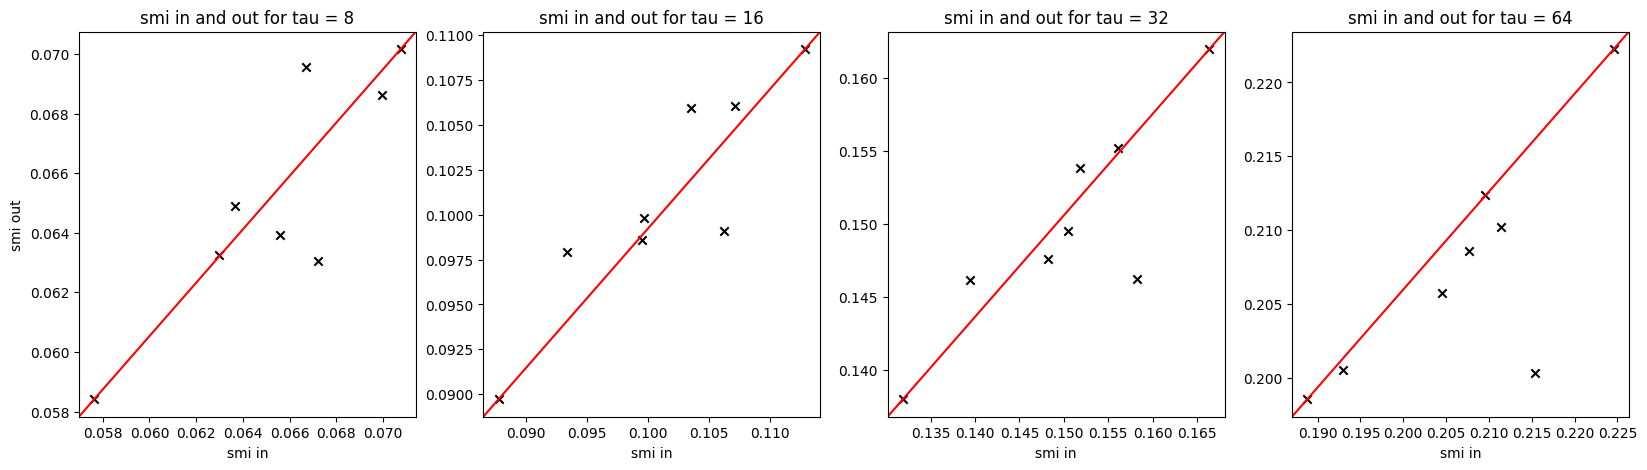

In [ ]:
#want a single plot, where for each dataset, mean pearson in and mean pearson out are plotted with error bars
taus = [0,1,2,3]

smi_in = {f'{tau}': [] for tau in taus}
smi_out = {f'{tau}': [] for tau in taus}
errors_in = {f'{tau}': [] for tau in taus}
errors_out = {f'{tau}': [] for tau in taus}

for file_number in file_numbers:
    values = []
    errors = []
    for tau in taus:
        for condition in ['left_attleft', 'right_attright']:
            values.append(smi_means[f'dataset_{file_number}'][condition][tau])
            errors.append(smi_stdevs[f'dataset_{file_number}'][condition][tau])
        smi_in[f'{tau}'].append(np.mean(values))
        errors_in[f'{tau}'].append(np.mean(errors))


    values = []
    errors = []
    for tau in taus:
        for condition in ['left_attright', 'right_attleft']:
            values.append(smi_means[f'dataset_{file_number}'][condition][tau])
            errors.append(smi_stdevs[f'dataset_{file_number}'][condition][tau])
        smi_out[f'{tau}'].append(np.mean(values))
        errors_out[f'{tau}'].append(np.mean(errors))

tau_values = [8, 16, 32, 64]

axs, fig = plt.subplots(1,4, figsize=(20, 5))
for tau, i in zip(taus, range(5)):
    fig[i].scatter(smi_in[f'{tau}'], smi_out[f'{tau}'], marker = 'x', color='k')
    fig[i].plot([0, 1], [0, 1], transform=fig[i].transAxes, color='r')
    fig[i].set_xlabel('smi in')
    fig[0].set_ylabel('smi out')
    fig[i].set_title(f'smi in and out for tau = {tau_values[tau]}')
plt.show()

